In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from generate_network_nodes import generate_network
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant, ArrayOutcome
import time

In [2]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [3]:
#define parameters
model.constants = [
    Constant("random_data", False),
    Constant("additional_nodes", 3),
    Constant('n', 25),
    # Constant('r', 150000),
    # Constant('scenario_var', 0),
]

model.uncertainties = [
    # 70000
    CategoricalParameter("r", [70000, 110000, 150000]),
    CategoricalParameter("scenario_var", [0, 1, 2]),
    # CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]),
#     CategoricalParameter("seed", [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030])
]

# set levers
model.levers = [
    CategoricalParameter('p', list(np.arange(1, 101, 1))),
    # CategoricalParameter("additional_nodes", [0, 1, 2, 3]),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome("optimal_facilities"),
    ArrayOutcome('non_zero_flows'),
    ScalarOutcome('add_nodes_used'),
]

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments, Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=12) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=11, policies=4, uncertainty_sampling=Samplers.FF, lever_sampling=Samplers.FF)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 20
  warnings.warn(
[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 9 scenarios * 100 policies * 1 model(s) = 900 experiments
  2%|▋                                      | 16/900 [06:10<4:17:23, 17.47s/it]

In [ ]:
pickle.dump( experiments, open( "results/experiments_all_with_new_max4.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_all_with_new_max4.p", "wb") )
# experiments = pickle.load(open("results/experiments_batch_run606new.p", "rb"))
# outcomes = pickle.load(open("results/outcomes_batch_run606new.p", "rb"))

# Why n=25?

In [3]:
experiments = pickle.load(open("results/experiments_batch_run_var_n.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run_var_n.p", "rb"))

In [4]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

In [5]:
df = df.loc[~df.policy.isin([1, 2, 3])]

In [6]:
df.n = df.apply(lambda x: '-' if x.additional_nodes==0 else x.n, axis=1)
df.additional_nodes = df.additional_nodes.apply(lambda x: 'None' if x==0 else x)
df.additional_nodes = df.additional_nodes.apply(lambda x: '2' if x==1 else x)
df.additional_nodes = df.additional_nodes.apply(lambda x: '1' if x==2 else x)
df.r = df.r.apply(lambda x: x/1000)

In [7]:
df

,r,additional_nodes,n,scenario,policy,model,total_flow,fraction_captured_total,serviceable_fraction,served_fraction,non_zero_flows,optimal_facilities,add_nodes_used
0,50.0,None,-,16,0,frlm,2.941841e+06,0.080884,0.081129,0.996978,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
1,60.0,None,-,17,0,frlm,2.941841e+06,0.090545,0.091274,0.992021,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
2,70.0,None,-,18,0,frlm,2.941841e+06,0.103037,0.103069,0.999685,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
3,80.0,None,-,19,0,frlm,2.941841e+06,0.219629,0.219942,0.998577,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
4,90.0,None,-,20,0,frlm,2.941841e+06,0.238536,0.240058,0.993662,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,110.0,1+2,25,22,15,frlm,2.941841e+06,0.757453,0.967891,0.782581,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
172,120.0,1+2,25,23,15,frlm,2.941841e+06,0.788310,0.979399,0.804892,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
173,130.0,1+2,25,24,15,frlm,2.941841e+06,0.800009,0.979399,0.816837,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
174,140.0,1+2,25,25,15,frlm,2.941841e+06,0.807083,0.991757,0.813791,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",13.0


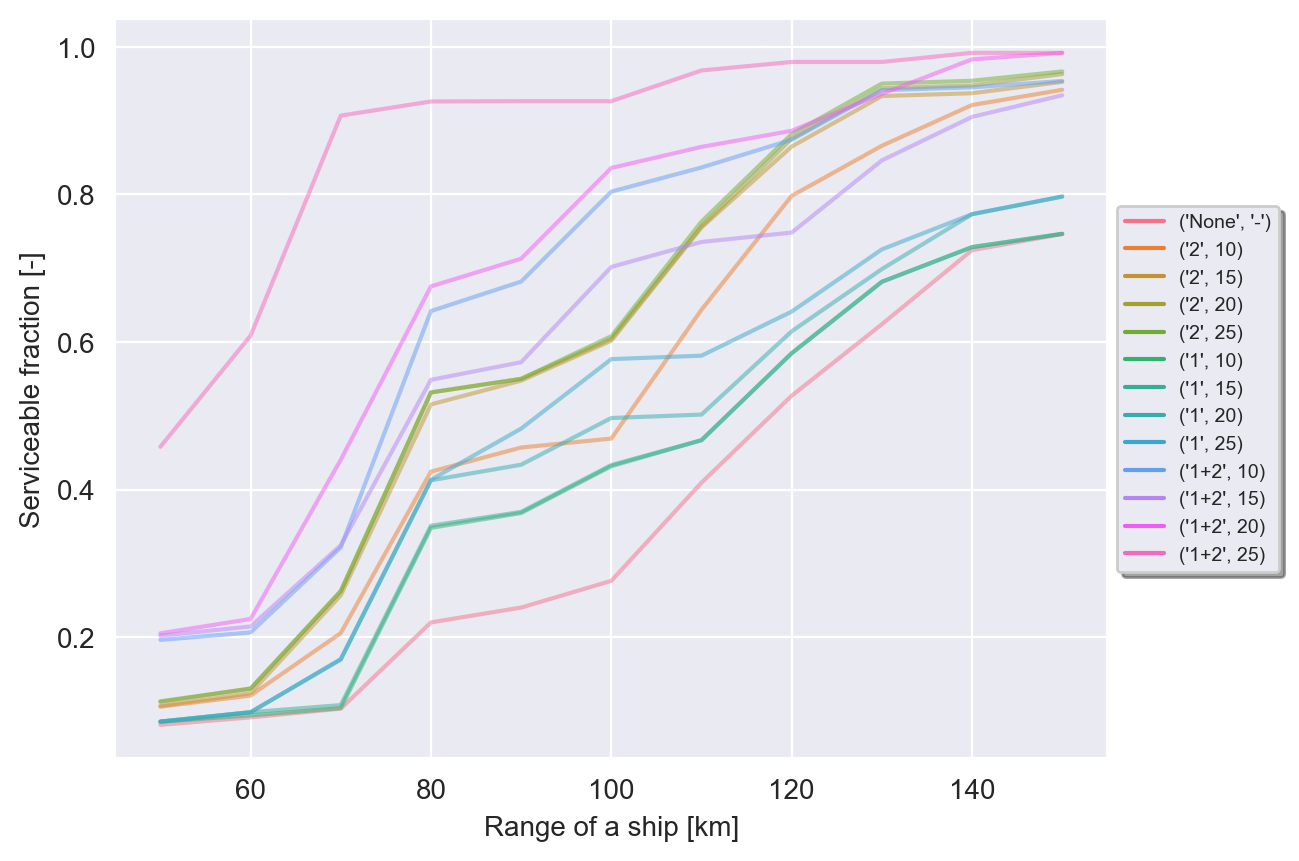

In [8]:
fig, ax = plt.subplots(dpi=200)

sns.lineplot(x='r', y='serviceable_fraction', hue=df[['additional_nodes', 'n']].apply(tuple, axis=1), data=df, ax=ax, alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7, fancybox=True, shadow=True)
plt.ylabel('Serviceable fraction [-]')
plt.xlabel('Range of a ship [km]')
plt.show()

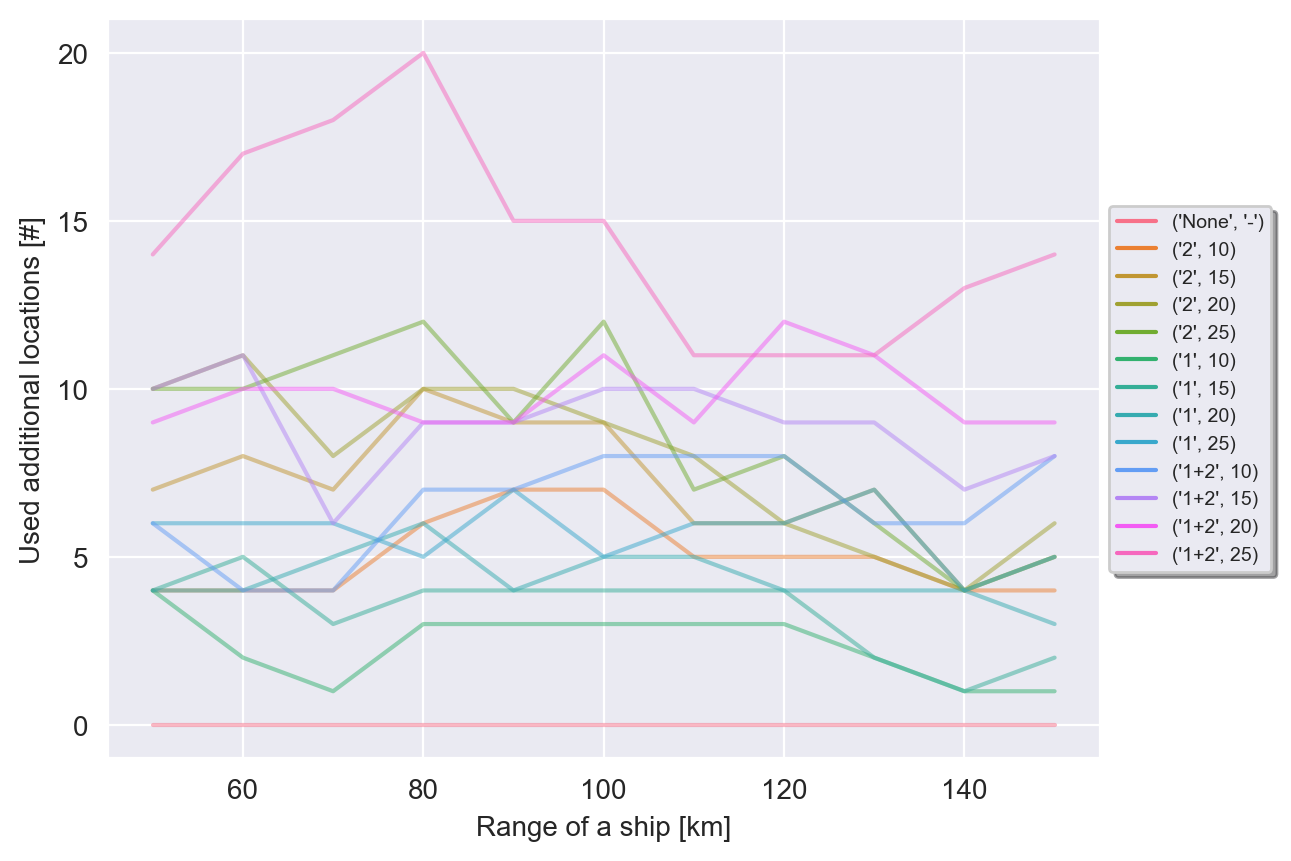

In [9]:
fig, ax = plt.subplots(dpi=200)

sns.lineplot(x='r', y='add_nodes_used', hue=df[['additional_nodes', 'n']].apply(tuple, axis=1), data=df, ax=ax, alpha=0.5)
# ax.legend(loc='lower right', title="(Heuristic, additional_nodes)", fontsize=7)
plt.yticks([0, 5, 10, 15, 20])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7, fancybox=True, shadow=True)
plt.ylabel('Used additional locations [#]')
plt.xlabel("Range of a ship [km]")
plt.show()

In [9]:

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==10)], ax=ax[0,0])
ax[0,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==15)], ax=ax[0,1])
# ax[0,1].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==20)], ax=ax[1,0])
# ax[1,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[1,1])
# ax[1,1].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

# sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[2,0])
# ax[2,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# # plt.title("Serviceable fraction considering various ranges")
# # plt.ylabel("Serviceable fraction")


# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")
# plt.xlabel("Vessel range")
# plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
# plt.legend(title="Heuristic", labels=["None", "None"])
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

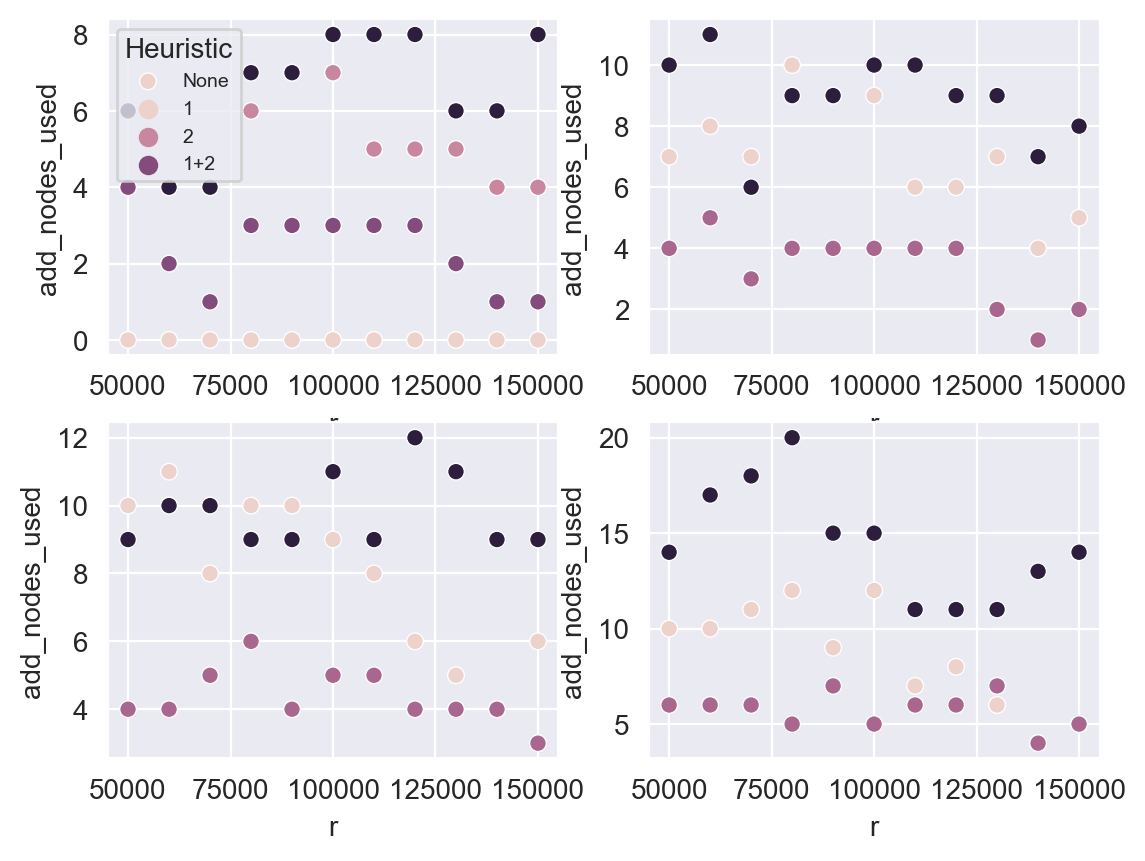

In [10]:
fig, ax = plt.subplots(2, 2, dpi=200)

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==10)], ax=ax[0,0])
ax[0,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==15)], ax=ax[0,1])
ax[0,1].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==20)], ax=ax[1,0])
ax[1,0].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[1,1])
ax[1,1].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")


# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")
# plt.xlabel("Vessel range")
# plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
# plt.legend(title="Heuristic", labels=["None", "None"])
plt.show()

# Performance heuristics n=25

In [21]:
experiments = pickle.load(open("results/experiments_batch_run_n_25.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run_n_25.p", "rb"))

In [22]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

In [23]:
df.additional_nodes = df.additional_nodes.apply(lambda x: 'None' if x==0 else x)
df.additional_nodes = df.additional_nodes.apply(lambda x: '2' if x==1 else x)
df.additional_nodes = df.additional_nodes.apply(lambda x: '1' if x==2 else x)
df.additional_nodes = df.additional_nodes.apply(lambda x: '1+2' if x==3 else x)
df.r = df.r.apply(lambda x: x/1000)

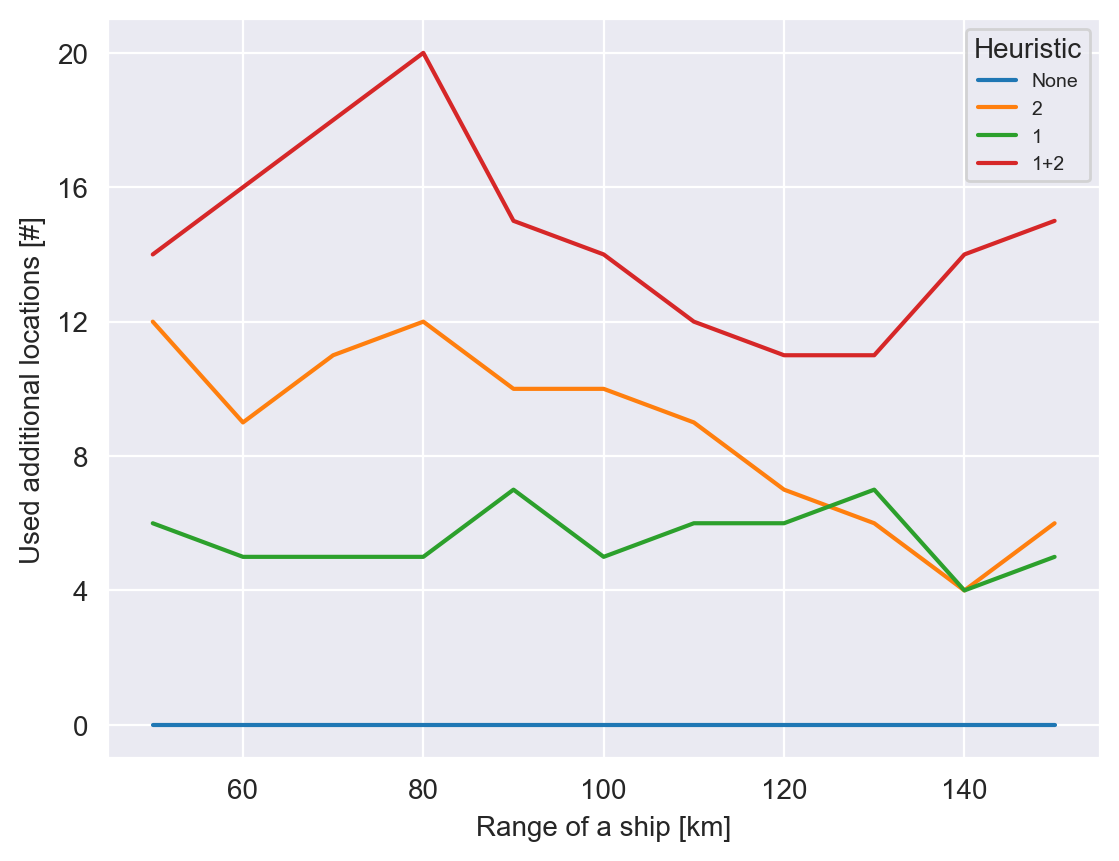

In [24]:
fig, ax = plt.subplots(dpi=200)
sns.lineplot(x='r', y='add_nodes_used', hue='additional_nodes', data=df, ax=ax)
# plt.title("Extra nodes used considering various ranges")
plt.ylabel("Used additional locations [#]")
plt.yticks(np.arange(0, 21, 4))
plt.xlabel("Range of a ship [km]")
plt.legend(title="Heuristic", fontsize=7)
plt.show()

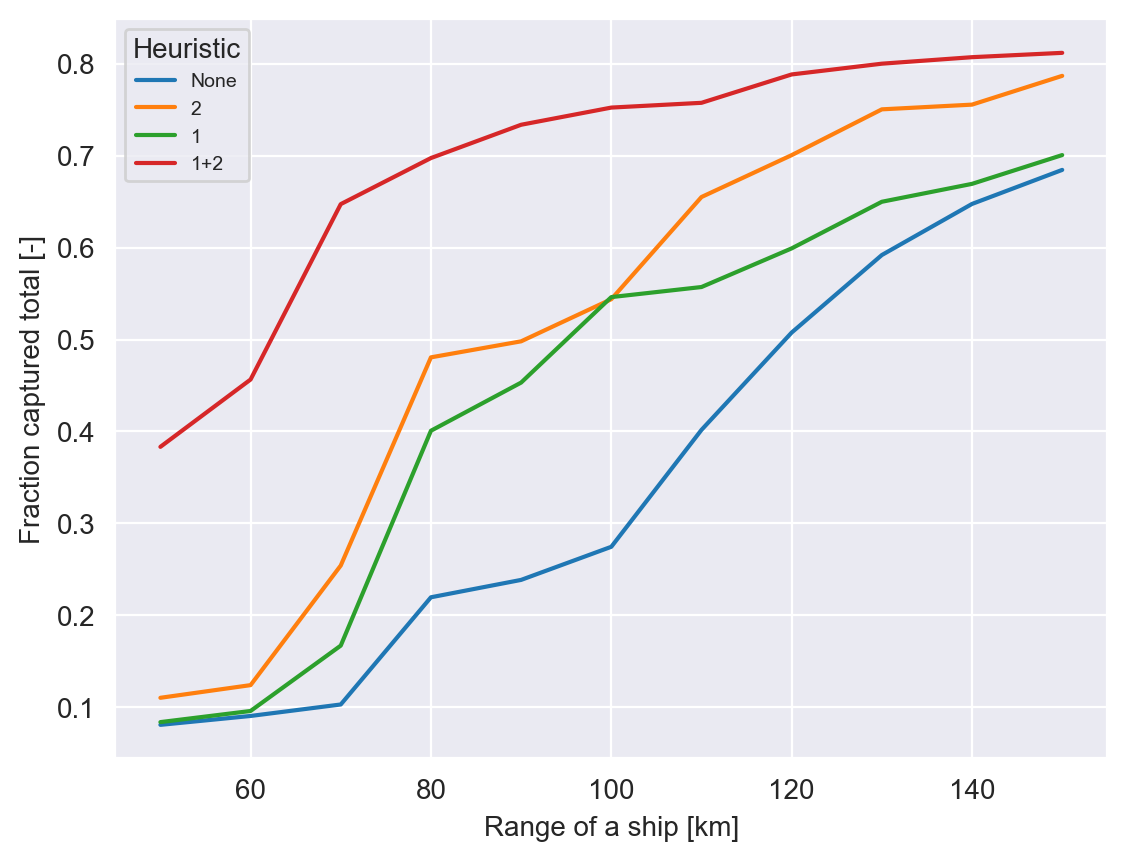

In [25]:
plt.subplots(dpi=200)
sns.lineplot(x='r', y='fraction_captured_total', hue='additional_nodes', data=df)
plt.legend(title="Heuristic", fontsize=7)
plt.ylabel('Fraction captured total [-]')
plt.xlabel('Range of a ship [km]')
plt.show()
# plt.title('Fraction captured total considering various ranges')

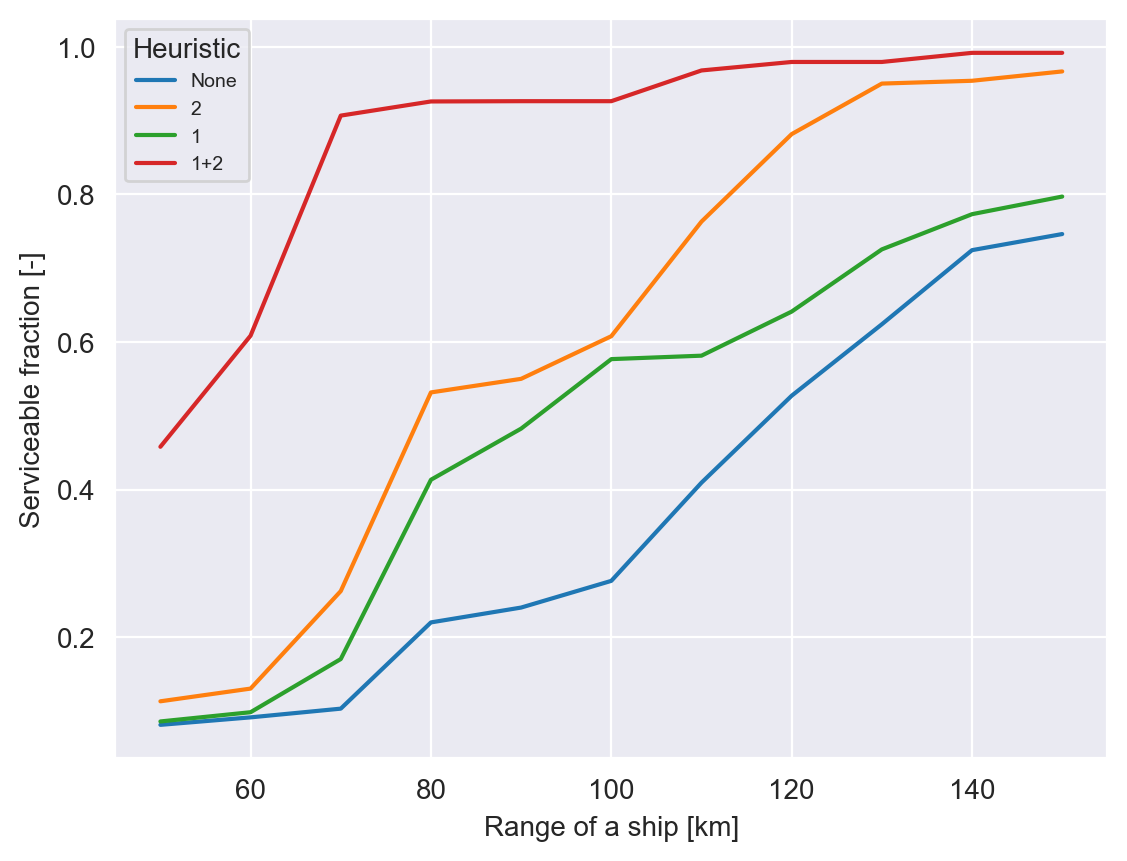

In [26]:
fig, ax =  plt.subplots(dpi=200)
sns.lineplot(x='r', y='serviceable_fraction', hue='additional_nodes', data=df, ax=ax)
plt.legend(title="Heuristic", fontsize=7)
plt.ylabel('Serviceable fraction [-]')
plt.xlabel('Range of a ship [km]')
plt.show()